![logo](../../picture/license_header_logo.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

# Requirement
You should complete both LSTM and CNN tutorials before starting this tutorial. This is because most of the function used will be based on  `data_module.py` and `deep_learning_module.py`

# Hybrid Model (CNN-LSTM)
This hands-on is to demonstrate the process of building a Hybrid model (CNN-LSTM) for univariate single-step time series. <br>
This hands-on consists of two main parts which are :<br>

1. Demonstration proccess of building hybrid model in synthetic data
2. Exercise of building hybrid model using minimum daily temperatures in city Melbourne, Australia. 


## What will we accomplish?
First, we will show the step in building the hybrid model (CNN-LSTM) :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)<br>
Step 2. Model Configuration for CNN-LSTM<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

Let's import the packages needed for this hands-on.

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import math

from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

# Part 1 : Demonstration of Building CNN-LSTM using Synthetic data
## Hyperparameter
Define the hyperparameter that is needed to tune the model.

In [2]:
split_ratio = 0.70
num_epochs = 60
window_size = 3
batch_size = 20
learning_rate=0.01
n_step = 1
#seed
torch.manual_seed(123)

# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and having the ability to perform the forecasting. <br>

1. First, we will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it to series data by using `pd.Series`.

In [3]:
#Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [4]:
# Create time index for Synthetic Data
univariate_series =pd.Series(univariate_series,pd.date_range("1/1/2020",
                                                             periods=len(univariate_series),
                                                            freq='D'))
univariate_series.head()

2020-01-01     0
2020-01-02    10
2020-01-03    20
2020-01-04    30
2020-01-05    40
Freq: D, dtype: int32

## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. As the graph below, it is shown that it is an increasing trend in data

>**Instruction** : <br>
Plot the graph using `univariate_series.plot` with the title `Synthetic Data"`

Text(0.5, 1.0, 'Synthetic Data')

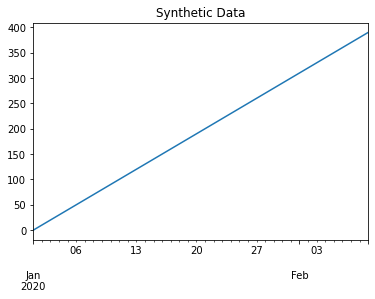

In [5]:
### BEGIN SOLUTION

univariate_series.plot()
plt.title("Synthetic Data")

### BEGIN SOLUTION

## Data Splitting
In Deep Learning, we will split the data into training and test dataset.The training data is used to train the model where the test data is used to validate the performance of the model
>**Instruction** : <br>
Split the data by indexing. Remember to split the time index for later use

In [6]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [7]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
train_time = univariate_series.index[:split_data]
test_time = univariate_series.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Normalization
Use MinMaxScaler to normalize the data into values ranging from 0 to 1.

In [8]:
scaler = MinMaxScaler().fit(train_data.values.reshape(-1, 1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1, 1))

test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

## Data Sequencing
Sequencing the data by taking in the univariate series into `x-feature` and `y-label`<br>
<img src = "../../picture/Data Sequencing in Univariate Single Step.png"  width="300" height  ="300" align="center" />

In [9]:
trainX ,trainY =  data_module.univariate_single_step(train_data_normalized,window_size)
testX , testY = data_module.univariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(25, 3, 1) trainY shape:(25, 1)

testX shape:(9, 3, 1) testY shape:(9, 1)


In [10]:
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY = testY.reshape(testY.shape[0],n_step,1)
print(f"trainY shape:{trainY.shape}")
print(f"testY shape:{testY.shape}")

trainY shape:(25, 1, 1)
testY shape:(9, 1, 1)


## Data Transform
Data need to be transformed from `NumPy` to `PyTorch` tensor before feeding into the CNN-LSTM model.

In [11]:

train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)



train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)


In [12]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([25, 3, 1])
train_data_y_label shape : torch.Size([25, 1, 1])
test_data_x_feature shape : torch.Size([9, 3, 1])
test_data_y_label shape : torch.Size([9, 1, 1])


## Data Transpose 
You are required to transpose the x-feature data in such a way that : <br>
>`(batch_size, number_of_features, sequence_length)`.

This is because CNN requires the input shape as `(batch_size, number_of_features, sequence_length)`. Hence, we will create a function that accepts the dictionary data of train data and test data as input. Transpose of the x-features for both train data and test data is done using `torch.transpose()`. The return of the function will be in a dictionary class type.

In [13]:
# Data Transpose
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

In [14]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([25, 1, 3])
train_data_y_label shape : torch.Size([25, 1, 1])
test_data_x_feature shape : torch.Size([9, 1, 3])
test_data_y_label shape : torch.Size([9, 1, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.

In [15]:
# Create Iterator
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)


# Step 2 : CNN-LSTM Configuration 

![CNN-LSTM](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/07/Convolutional-Neural-Network-Long-Short-Term-Memory-Network-Archiecture.png)
<center><b>Data Flow in CNN-LSTM</b></center>

>**How does it work**?
The input data will first pass to the CNN model followed by the LSTM model as shown in the figure above.<br>

>**How to initialize the configuration**?<br>
    1. First, you need to initialize the constructor just like the initialization in our previous tutorial Python class `CNN`. The `forward()` method in `CNN_hybrid` will be a similar configuration to the one from the previous tutorial.<br>
    2. Secondly, create a new class called `Combine`. Initialize the constructor like the LSTM model with an extra line: `self.cnn = CNN(n_features,n_step)` to enable its access to the `CNN` class. In the `forward()` method, add in `c_out = self.cnn(x)` as the first line of the code to take the input data and input it to the CNN class. The return output of CNN needs to be reshaped before inputting to LSTM.<br>



In [16]:
class CNN_hybrid(nn.Module):
    def __init__(self,n_features,n_step):
        super(CNN_hybrid, self).__init__()
        self.n_features = n_features
        self.n_step = n_step
        self.conv1 = nn.Conv1d(in_channels = n_features,out_channels=10, kernel_size=2)
        self.poo1 = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, n_step)

    def forward(self, x):
        x = self.poo1(F.relu(self.conv1(x)))
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class Combine(nn.Module):
    def __init__(self,n_features,n_step,hidden_size,num_layers):
        super(Combine, self).__init__()
        self.n_features = n_features
        self.n_step = n_step
        self.hidden_size = hidden_size
        self.num_layers = num_layers 

        self.cnn = CNN_hybrid(n_features,n_step)

        self.lstm = nn.LSTM(
            input_size= n_features,
            hidden_size= hidden_size,
            num_layers= num_layers ,
            batch_first=True)
        self.linear = nn.Linear(hidden_size,n_step)

    def forward(self, x):
        # The data flow into CNN first
        c_out = self.cnn(x)

        # Reshape the c_out to fit in LSTM
        c_out = torch.reshape(c_out,(c_out.shape[0],c_out.shape[1],1))

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # The output of CNN will flow into LSTM 
        out, (hn, cn) = self.lstm(c_out, (h0.detach(), c0.detach()))
        
        out = out[:, -1, :]
        
        out = self.linear(out)
        

        return (out)

## Input Model

In [17]:
# seed
torch.manual_seed(123)

n_feature = train_data_dict['train_data_x_feature'].shape[1]
hidden_size = 32 
num_layers = 1

model = Combine(n_features = n_feature,
             n_step = n_step,
             hidden_size = hidden_size,
             num_layers = num_layers)
print(model.eval())

#loss function
loss_fn = torch.nn.MSELoss()

#optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Combine(
  (cnn): CNN_hybrid(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): AdaptiveMaxPool1d(output_size=1)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [18]:
# seed
torch.manual_seed(123)

def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

Combine(
  (cnn): CNN_hybrid(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): AdaptiveMaxPool1d(output_size=1)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

                             Kernel Shape Output Shape Params Mult-Adds
Layer                                                                  
0_cnn.Conv1d_conv1             [1, 10, 2]  [20, 10, 2]   30.0      40.0
1_cnn.AdaptiveMaxPool1d_poo1            -  [20, 10, 1]      -         -
2_cnn.Linear_fc1                 [10, 20]     [20, 20]  220.0     200.0
3_cnn.Linear_fc2                  [20, 1]      [20, 1]   21.0      20.0
4_lstm                                  -  [20, 1, 32]  4.48k    4.224k
5_linear                          [32, 1]      [20, 1]   33.0      32.0
-------------------------------------------------------------------------
                      Totals
Total params          4.784k
Trainable params      4.784k
Non-trainable params     0.0
Mult-Adds             4.516k
                             Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                                    
0_cnn.Conv1d_conv1             [1, 10, 2]  [20, 10, 2]   

# Step 3 : Training

In [20]:
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

# Step 4 : Validation 
A learning curve is plotted to define how well the data is fitting the model 

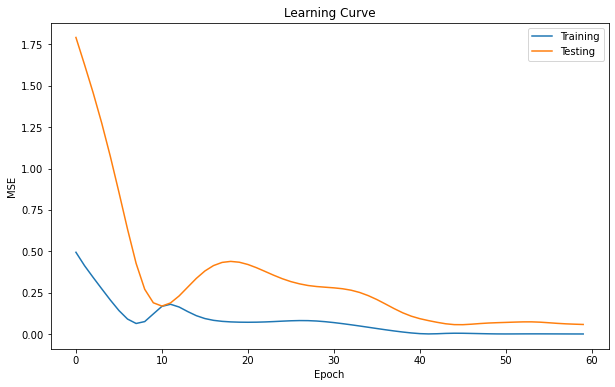

Epoch : 0 , training loss : 0.49378840923309325 , validation loss : 1.7917041778564453
Epoch : 1 , training loss : 0.4129299998283386 , validation loss : 1.6274195909500122
Epoch : 2 , training loss : 0.3419968247413635 , validation loss : 1.4577746391296387
Epoch : 3 , training loss : 0.2731207966804504 , validation loss : 1.2741748094558716
Epoch : 4 , training loss : 0.205336594581604 , validation loss : 1.0730152130126953
Epoch : 5 , training loss : 0.14186214208602904 , validation loss : 0.8563950061798096
Epoch : 6 , training loss : 0.09037506878376007 , validation loss : 0.6336524486541748
Epoch : 7 , training loss : 0.06368815898895264 , validation loss : 0.4264334738254547
Epoch : 8 , training loss : 0.07509501948952675 , validation loss : 0.27023622393608093
Epoch : 9 , training loss : 0.12137907594442368 , validation loss : 0.18873776495456696
Epoch : 10 , training loss : 0.16695354860275985 , validation loss : 0.16878217458724976
Epoch : 11 , training loss : 0.1797507844865

In [21]:
# Create Learining Curve 
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast values and calculating the RMSE. 

> For this exercise, use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

In [22]:
# make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])

In [23]:
# Assign evaluation key
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
    y_test_prediction,
    train_data_dict,
    test_data_dict)

# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)


In [24]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([25, 1])
test_data_output shape : torch.Size([9, 1])


In [25]:
# Section 3 : Invert predictions
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

In [26]:
data_module.sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (25, 1)
test_data_prediction shape : (9, 1)
train_data_output shape : (25, 1)
test_data_output shape : (9, 1)


In [27]:
# List the forecast value
data_module.list_forecast_value(output_data,prediction) 

Test Data			Forecast
[310.]		[280.90417]
[320.]		[284.09375]
[330.]		[287.20572]
[340.]		[289.06573]
[349.99997]		[290.0198]
[360.]		[290.97293]
[370.]		[291.9251]
[380.]		[292.87628]
[390.]		[293.8265]


In [28]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.27 RMSE
Test Score: 64.86 RMSE


# Step 6 : Forecast Plot

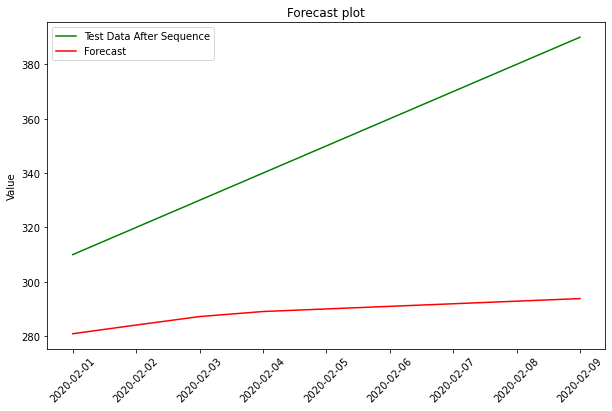

In [29]:
data_module.single_step_plot(original_test_data = test_data,
                            sequence_test_data = output_data['test_data_output'],
                            forecast_data = prediction['test_data_prediction'],
                            test_time = test_time,
                            window_size =  window_size,
                            original_plot=False,
                            multivariate=False)

# Part 2 : Exercise for Univariate 
## Task : Use Hybrid model (CNN-LSTM) to predict the temperature for Melbourne

### Introduction
You are given a set of dataset that describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia. The units are in degrees Celsius and there are 3650 observations.

### Data Sources :
[The source of the data is credited as the Australian Bureau of Meteorology.](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)

## Hyperparameter
>**Instruction** : <br>
You are required to fill `None` with a suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 10 RMSE<br>
Test Score <= 10 RMSE<br>

In [30]:
# Hyperparameter
num_epochs_temperature = 100
batch_size_temperature = 30
window_size_temperature = 12
learning_rate_temperature = 0.001
n_step_temperature = 1 
split_data_ratio_temperature = 0.70
#seed
torch.manual_seed(123)

# Step 1 : Data Preparation
>**Instruction** : <br>
Read the `CSV` file using `pd.read_csv`<br>
Your file path `https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv`

>**Expected Result**<br>
Example of the first 5 rows of data:

---|	Date|	Temp
---|---|---
0|	1981-01-01|	20.7
1|	1981-01-02|	17.9
2|	1981-01-03|	18.8
3|	1981-01-04|	14.6
4|	1981-01-05|	15.8

In [31]:
# Read CSV file 
### BEGIN SOLUTION
temperature = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
### END SOLUTION
temperature.head() 

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


>**Instruction** : <br>
Convert the `Date` by using `pd.to_datetime`
Set the index as 'Date' using `df.set_index`

>**Expected Result** : <br>
Example of the first 5 rows:

Date|	Temp
---|---
1981-01-01|	20.7
1981-01-02|	17.9
1981-01-03|	18.8
1981-01-04|	14.6
1981-01-05|	15.8

In [32]:
### BEGIN SOLUTION
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature = temperature.set_index('Date')
### END SOLUTION
temperature.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


>**Instruction** : <br>
Save the data in `Series` format using `pd.Series`

>**Expected Result** : <br>
Example of the first 5 rows of data:

Date|---
---|---
1981-01-01|    20.7
1981-01-02|    17.9
1981-01-03|    18.8
1981-01-04|    14.6
1981-01-05|    15.8

In [33]:
### BEGIN SOLUTION
temperature_ts = pd.Series(temperature['Temp'])
### END SOLUTION
temperature_ts.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality.
>**Instruction** : <br>
Use `df.plot()` to plot the `temperature_ts`

<AxesSubplot:xlabel='Date'>

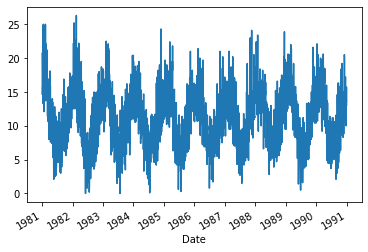

In [34]:
## BEGIN SOLUTION
temperature_ts.plot()
### END SOLUTION

## Data Splitting

In [35]:
# Create split data ratio
split_ratio = round(len(temperature_ts)*split_data_ratio_temperature)

In [36]:
# Split data by indexing 
train_data_temperature= temperature_ts[:split_ratio]
test_data_temperature = temperature_ts[split_ratio:]
train_time_temperature = temperature_ts.index[:split_ratio ]
test_time_temperature = temperature_ts.index[split_ratio:]
print("train_data_shampoo_shape")
print(train_data_temperature.shape)
print("test_data_shampoo_shape")
print(test_data_temperature.shape)

train_data_shampoo_shape
(2555,)
test_data_shampoo_shape
(1095,)


## Data Standardization
>**Instruction** : <br>
Use `StandardScaler()` to  standardize the data, save your data scaler into `scaler_temperature`.<br>
Train and test scaled data into `scaler_train_shampoo_data ` and `test_data_scaled_temperature`.<br>

Example :<br>
`train_data_scaled_temperature = scaler_temperature.transform(train_data_temperature.values.reshape(-1, 1))`


In [37]:
### BEGIN SOLUTION
scaler_temperature = StandardScaler().fit(train_data_temperature.values.reshape(-1, 1))
train_data_scaled_temperature = scaler_temperature.transform(train_data_temperature.values.reshape(-1, 1))
test_data_scaled_temperature = scaler_temperature.transform(test_data_temperature.values.reshape((-1, 1)))
### END SOLUTION

## Data Sequencing 
>**Instruction** : <br>
Use `data_module.univariate_single_step` to perform sliding window operation by taking the scaled data and save your data into respective `x` and `y` variable.<br>

Example :<br>
`trainX_temperature ,trainY_temperature =  data_module.univariate_single_step(train_data_scaled_temperature,
                                                                             window_size_temperature)`

In [38]:
### BEGIN SOLUTION
trainX_temperature ,trainY_temperature =  data_module.univariate_single_step(train_data_scaled_temperature,
                                                                             window_size_temperature)

testX_temperature , testY_temperature = data_module.univariate_single_step(test_data_scaled_temperature,
                                                                           window_size_temperature)
### END SOLUTION
print(f"trainX shape:{trainX_temperature.shape} trainY shape:{trainY_temperature.shape}\n")
print(f"testX shape:{testX_temperature.shape} testX shape:{testY_temperature.shape}")

trainX shape:(2543, 12, 1) trainY shape:(2543, 1)

testX shape:(1083, 12, 1) testX shape:(1083, 1)


In [39]:
trainY_temperature= trainY_temperature.reshape(trainY_temperature.shape[0],n_step,1)
testY_temperature= testY_temperature.reshape(testY_temperature.shape[0],n_step,1)
print(f"trainY shape:{trainY_temperature.shape}")
print(f"testY shape:{testY_temperature.shape}")

trainY shape:(2543, 1, 1)
testY shape:(1083, 1, 1)


## Data Transform
Data has to be transformed from `NumPy` to `PyTorch` tensor before feeding into the CNN-LSTM model.

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [40]:
# Key Assign 
### BEGIN SOLUTION
train_data_dict_temperature ,test_data_dict_temperature = data_module.key_assign(trainingX = trainX_temperature  , 
                       testingX = testX_temperature, 
                       trainingY = trainY_temperature, 
                       testingY = testY_temperature)
### END SOLUTION

# Transform data
### BEGIN SOLUTION
train_data_dict_temperature ,test_data_dict_temperature= data_module.transform(train_data_dict_temperature ,
                                                                          test_data_dict_temperature)
### END SOLUTION

In [41]:
data_module.sanity_check(train_data_dict_temperature , test_data_dict_temperature)

train_data_x_feature shape : torch.Size([2543, 12, 1])
train_data_y_label shape : torch.Size([2543, 1, 1])
test_data_x_feature shape : torch.Size([1083, 12, 1])
test_data_y_label shape : torch.Size([1083, 1, 1])


## Data Transpose 
You are required to transpose the x-feature data in such a way that : <br>
>`(batch_size, number_of_features, sequence_length)`.

This is because CNN requires the input shape as `(batch_size, number_of_features, sequence_length)` .

>**Instruction** : <br>
Use `transpose` function in `data_module.py` to transpose the suitable input data for CNN-LSTM model.

In [42]:
### BEGIN SOLUTION
train_data_dict_temperature , test_data_dict_temperature = data_module.transpose(train_data_dict_temperature,
                                                                     test_data_dict_temperature)
### END SOLUTION

## Data Iterator
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator

In [43]:
# Create Iterator
### BEGIN SOLUTION
train_iter_temperature , test_iter_temperature = data_module.iterator(train_data_dict_temperature ,
                                                                      test_data_dict_temperature,
                                                                      batch_size = batch_size_temperature)
### END SOLUTION

# Step 2 : CNN-LSTM Configuration 
>**Instruction** : <br>
You are suggested to configure your own CNN-LSTM model. Name the `Combine` class as `Combine_temperature` 

In [44]:
class CNN(nn.Module):
    def __init__(self,n_features,n_step):
        super(CNN, self).__init__()
        ### BEGIN SOLUTION
        self.n_features = n_features
        self.n_step = n_step
        self.conv1 = nn.Conv1d(in_channels = n_features,out_channels=10, kernel_size=2)
        self.poo1 = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, n_step)
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.poo1(F.relu(self.conv1(x)))
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        ### END SOLUTION
        return x


class Combine_temperature(nn.Module):
    def __init__(self,n_features,n_step,hidden_size,num_layers):
        super(Combine_temperature, self).__init__()
        ### BEGIN SOLUTION
        self.n_features = n_features
        self.n_step = n_step
        self.hidden_size = hidden_size
        self.num_layers = num_layers 

        self.cnn = CNN(n_features,n_step)

        self.lstm = nn.LSTM(
            input_size= n_features,
            hidden_size= hidden_size,
            num_layers= num_layers ,
            batch_first=True)
        self.linear = nn.Linear(hidden_size,n_step)
        ### END SOLUTION

    def forward(self, x):
        # The data flow into CNN first
        c_out = self.cnn(x)

        # Reshape the c_out to fit in LSTM
        c_out = torch.reshape(c_out,(c_out.shape[0],c_out.shape[1],1))

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # The output of CNN will flow into LSTM 
        out, (hn, cn) = self.lstm(c_out, (h0.detach(), c0.detach()))
        
        out = out[:, -1, :]
        
        out = self.linear(out)
        ### END SOLUTION
        

        return (out)

## Input Model



>**Instruction** : <br>
Use the `Combine_temperature` configuration as the model for the temperature data. Use `Adam` as the optimizer and `MSE` as the loss function.

In [45]:
# seed
torch.manual_seed(123)

n_feature_temperature = train_data_dict_temperature['train_data_x_feature'].shape[1]
hidden_size_temperature = 16
num_layers_temperature = 1

### BEGIN SOLUTION
model_temperature = Combine_temperature(n_feature_temperature,n_step_temperature,hidden_size_temperature,num_layers_temperature)

#loss function
loss_fn_temperature = torch.nn.MSELoss()

#optimiser
optimizer_temperature = torch.optim.Adam(model_temperature.parameters(), lr=learning_rate_temperature)
### END SOLUTION

In [46]:
seq_length_temperature = train_data_dict_temperature['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size_temperature,
                      n_feature_temperature ,
                      seq_length_temperature),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model_temperature,inputs))

                             Kernel Shape  Output Shape  Params Mult-Adds
Layer                                                                    
0_cnn.Conv1d_conv1             [1, 10, 2]  [30, 10, 11]    30.0     220.0
1_cnn.AdaptiveMaxPool1d_poo1            -   [30, 10, 1]       -         -
2_cnn.Linear_fc1                 [10, 20]      [30, 20]   220.0     200.0
3_cnn.Linear_fc2                  [20, 1]       [30, 1]    21.0      20.0
4_lstm                                  -   [30, 1, 16]  1.216k    1.088k
5_linear                          [16, 1]       [30, 1]    17.0      16.0
--------------------------------------------------------------------------
                      Totals
Total params          1.504k
Trainable params      1.504k
Non-trainable params     0.0
Mult-Adds             1.544k
                             Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                                                     
0_cnn.Conv1d_conv1             [1, 10,

In [47]:
# seed
torch.manual_seed(123)

def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_temperature.apply(weights_init)

Combine_temperature(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): AdaptiveMaxPool1d(output_size=1)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

# Step 3 : Training

In [48]:
torch.manual_seed(123)
train_loss_temperature,val_loss_temperature = deep_learning_module.training(num_epochs_temperature,
                                                                    train_iter_temperature,
                                                                    test_iter_temperature,
                                                                    optimizer_temperature,
                                                                    loss_fn_temperature,
                                                                    model_temperature)

# Step 4 : Validation

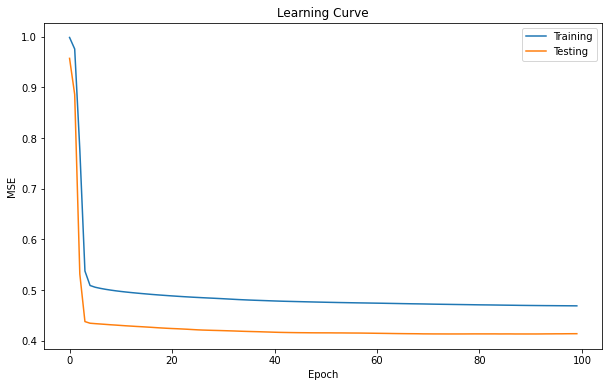

Epoch : 0 , training loss : 0.9985006960578383 , validation loss : 0.9572441407848263
Epoch : 1 , training loss : 0.9758131025791918 , validation loss : 0.8860651324000055
Epoch : 2 , training loss : 0.7770931489159167 , validation loss : 0.5314532745000068
Epoch : 3 , training loss : 0.537343065018172 , validation loss : 0.4375603802068742
Epoch : 4 , training loss : 0.5087938724401379 , validation loss : 0.4343102104198239
Epoch : 5 , training loss : 0.5053702884896084 , validation loss : 0.43350399873758616
Epoch : 6 , training loss : 0.5031764328690715 , validation loss : 0.4327814189763611
Epoch : 7 , training loss : 0.5013193643168113 , validation loss : 0.43205276342144966
Epoch : 8 , training loss : 0.49974828242458696 , validation loss : 0.4312915827593975
Epoch : 9 , training loss : 0.4983278716285539 , validation loss : 0.43066104321928894
Epoch : 10 , training loss : 0.4970620718121388 , validation loss : 0.42994417613398006
Epoch : 11 , training loss : 0.4959346610661618 ,

In [49]:
data_module.learning_curve(num_epochs = num_epochs_temperature , train_loss = train_loss_temperature , val_loss = val_loss_temperature )


# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast values and calculating the RMSE.
>**Instruction** : <br>
Use the function created in `data_module.py` to perform the task in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test dat

In [50]:
# Section 1 : make predictions
### BEGIN SOLUTION
with torch.no_grad():
    y_train_prediction_temperature = model_temperature(train_data_dict_temperature['train_data_x_feature'])
    y_test_prediction_temperature = model_temperature(test_data_dict_temperature['test_data_x_feature'])
### END SOLUTION

In [51]:
# Assign evaluation key
### BEGIN SOLUTION
prediction_temperature , output_temperature = data_module.key_assign_evaluation(y_train_prediction_temperature,
                                                                    y_test_prediction_temperature,
                                                                    train_data_dict_temperature,
                                                                    test_data_dict_temperature)
### END SOLUTION


# Section 2 : Reshape to original data
# Squeeze the output dimension
### BEGIN SOLUTION
output_data_temperature = data_module.squeeze_dimension(output_temperature)
### END SOLUTION

In [52]:
data_module.sanity_check(data_1 = output_temperature,data_2 = {})

train_data_output shape : torch.Size([2543, 1])
test_data_output shape : torch.Size([1083, 1])


In [53]:
# Section 3 : Invert the scaling back to orignal data value
### BEGIN SOLUTION
prediction_temperature = data_module.inverse_scaler(prediction_temperature,scaler_temperature)
output_data_temperature  = data_module.inverse_scaler(output_data_temperature ,scaler_temperature)
### END SOLUTION

In [54]:
# List the forecast value
### BEGIN SOLUTION
data_module.list_forecast_value(output_data_temperature,prediction_temperature) 
### END SOLUTION

Test Data			Forecast
[22.4]		[14.9955015]
[21.4]		[15.5577]
[20.9]		[15.687998]
[17.6]		[15.68926]
[15.5]		[16.572258]
[16.6]		[16.563574]
[16.2]		[16.565306]
[15.6]		[16.565306]
[14.5]		[16.570417]
[14.]		[16.222725]
[15.6]		[15.922064]
[12.3]		[15.922064]
[11.6]		[14.768543]
[12.6]		[14.160766]
[14.9]		[13.9098]
[17.300001]		[13.802187]
[21.4]		[13.754176]
[23.4]		[14.276303]
[14.4]		[14.715339]
[14.1]		[14.715339]
[15.]		[14.715339]
[14.5]		[14.715339]
[15.1]		[14.715339]
[13.900001]		[14.715339]
[13.4]		[15.343761]
[9.2]		[15.8544855]
[12.5]		[13.102722]
[15.1]		[13.057842]
[12.1]		[13.057842]
[14.5]		[12.632841]
[16.3]		[12.271707]
[16.5]		[12.435296]
[14.9]		[12.554744]
[13.2]		[12.554744]
[11.8]		[12.554744]
[13.6]		[12.554744]
[16.2]		[12.554744]
[14.1]		[14.234973]
[13.5]		[14.058261]
[15.]		[14.016606]
[14.8]		[14.016606]
[16.2]		[14.016606]
[16.2]		[14.016606]
[13.3]		[13.97277]
[15.3]		[13.97277]
[18.4]		[13.97277]
[16.2]		[14.888962]
[16.3]		[14.996829]
[12.4]		[14.996829]

[4.4]		[7.459869]
[5.7000003]		[7.459869]
[10.2]		[7.459869]
[10.2]		[7.646879]
[9.3]		[8.149882]
[5.3999996]		[8.198051]
[4.9999995]		[8.198051]
[7.6]		[8.158872]
[9.6]		[8.158872]
[10.4]		[8.158872]
[11.2]		[8.158872]
[9.1]		[8.287192]
[11.2]		[8.712545]
[6.8]		[8.726342]
[8.3]		[8.206298]
[9.7]		[8.206298]
[9.6]		[8.206298]
[9.8]		[8.206298]
[10.8]		[9.16966]
[9.2]		[9.081994]
[6.5]		[9.060216]
[8.1]		[8.906003]
[7.3]		[8.824059]
[7.9]		[8.824059]
[6.]		[8.746822]
[4.9999995]		[8.454993]
[6.8]		[7.8330545]
[9.8]		[7.931106]
[5.7000003]		[8.200738]
[8.6]		[8.200738]
[10.6]		[8.063695]
[7.8]		[8.130657]
[7.7000003]		[8.130657]
[8.6]		[8.130657]
[6.5]		[8.130657]
[6.9]		[8.130657]
[6.4]		[8.130657]
[8.5]		[8.490829]
[7.8]		[8.556796]
[9.3]		[8.556796]
[8.400001]		[8.978061]
[7.8]		[8.716072]
[7.4]		[8.515714]
[7.7000003]		[8.515714]
[8.9]		[8.515714]
[9.7]		[8.515714]
[9.9]		[8.6391945]
[6.1000004]		[8.702303]
[6.6]		[8.550223]
[7.6]		[8.209684]
[7.4]		[8.209684]
[8.]		[8.130218]
[2.1]

In [55]:
# calculate root mean squared error
### BEGIN SOLUTION
trainScore_temperature,testScore_temperature = data_module.rmse(prediction_temperature,output_data_temperature)
print('Train Score: %.2f RMSE' % (trainScore_temperature))
print('Test Score: %.2f RMSE' % (testScore_temperature))
### END SOLUTION

Train Score: 2.79 RMSE
Test Score: 2.63 RMSE


# Step 6 : Forecast Plot
>Instruction :<br>
Use `data_module.single_step_plot` function to plot the forecast result.

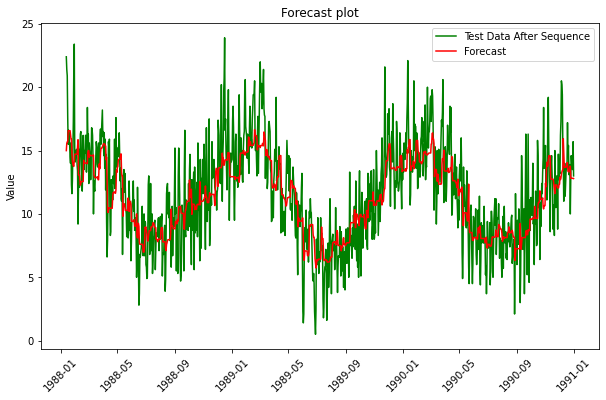

In [56]:
### BEGIN SOLUTION
data_module.single_step_plot(original_test_data = test_data_temperature,
                            sequence_test_data = output_data_temperature['test_data_output'],
                            forecast_data = prediction_temperature['test_data_prediction'],
                            test_time = test_time_temperature,
                            window_size =  window_size_temperature,
                            original_plot= False,
                            multivariate=False)
### END SOLUTION

## Summary
In this tutorial you should have learnt:

1. The flow of using Hybrid Model (CNN-LSTM) to perform univariate forecasting.<br>
2. The configuration of the Hybrid Model (CNN-LSTM) and the concept of it<br>

Congratulations, that concludes this lesson.<br>

## Reference 
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
2. [[CNN]Time-series Forecasting with Pytorch](https://www.kaggle.com/hanjoonchoe/cnn-time-series-forecasting-with-pytorch)
3. [PyTorch: learning conv1D,conv2D and conv3D](https://programmer.group/pytorch-learning-conv1d-conv2d-and-conv3d.html)